In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from router_utils import (
    GEN_STR_CONFIGS,
    get_gen_str,
    short_model_name,
    load_model_data,
    get_latest_probe_preds,
    merge_probe_predictions,
    compute_tier_costs,
    route_problems_by_probe_pred,
    oracle_router,
    route_problems_oracle_utility,
    build_comparison_data,
    plot_cost_vs_accuracy,
    plot_probe_histograms,
    dataset_title,
)

In [ ]:
# "gneubig_aime-1983-2024", "DigitalLearningGmbH_MATH-lighteval", "openai_gsm8k"

In [ ]:
# ── Configuration ──────────────────────────────────────────
ROUTED_DATASET     = "DigitalLearningGmbH_MATH-lighteval" #"DigitalLearningGmbH_MATH-lighteval"
PROBE_MODEL_TYPE   = "linear_eoi_probe"
CHOSEN_METRIC      = "majority_vote_is_correct"
SWEEP_VALUE_AMOUNTS = 10
DATA_DIR           = "../data"

MODEL_POOL = [
    "Qwen/Qwen2.5-Math-7B-Instruct",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "openai/gpt-oss-20b_low",
    "openai/gpt-oss-20b_medium",
    "openai/gpt-oss-20b_high",
]

print(f"Dataset : {ROUTED_DATASET}")
print(f"Probe   : {PROBE_MODEL_TYPE}")
print(f"Metric  : {CHOSEN_METRIC}")
print(f"\nModels + gen strings:")
for m in MODEL_POOL:
    print(f"  {m}: {get_gen_str(m)}")

Dataset : DigitalLearningGmbH_MATH-lighteval
Probe   : linear_eoi_probe
Metric  : majority_vote_is_correct

Models + gen strings:
  Qwen/Qwen2.5-Math-7B-Instruct: maxlen_3000_k_5_temp_0.7
  deepseek-ai/DeepSeek-R1-Distill-Qwen-7B: maxlen_32768_k_5_temp_0.6
  openai/gpt-oss-20b_low: maxlen_131072_k_5_temp_1.0
  openai/gpt-oss-20b_medium: maxlen_131072_k_5_temp_1.0
  openai/gpt-oss-20b_high: maxlen_131072_k_5_temp_1.0


In [15]:
# ── Load test / train data ─────────────────────────────────
test_dfs, train_dfs = {}, {}

for model in MODEL_POOL:
    t, tr = load_model_data(model, ROUTED_DATASET, DATA_DIR)
    if t is not None:
        test_dfs[model], train_dfs[model] = t, tr
        print(f"✓ {model}: {len(t)} test, {len(tr)} train")

print(f"\n✓ Loaded {len(test_dfs)}/{len(MODEL_POOL)} models")

✓ Qwen/Qwen2.5-Math-7B-Instruct: 5000 test, 6000 train
✓ deepseek-ai/DeepSeek-R1-Distill-Qwen-7B: 5000 test, 4800 train
✓ openai/gpt-oss-20b_low: 5000 test, 6000 train
✓ openai/gpt-oss-20b_medium: 5000 test, 4800 train
✓ openai/gpt-oss-20b_high: 5000 test, 7500 train

✓ Loaded 5/5 models


In [16]:
# ── Load & merge probe predictions ─────────────────────────
test_dfs_with_probes = {}

for model in MODEL_POOL:
    gen_str = get_gen_str(model)
    preds = get_latest_probe_preds(
        ROUTED_DATASET, model, gen_str,
        probe_model_type=PROBE_MODEL_TYPE,
        chosen_metric=CHOSEN_METRIC,
        data_dir=DATA_DIR,
    )
    if preds is not None:
        test_dfs_with_probes[model] = merge_probe_predictions(test_dfs[model], preds)
        pp = test_dfs_with_probes[model]["probe_pred"]
        print(f"  ✓ {model}: {len(pp)} rows, pred ∈ [{pp.min():.4f}, {pp.max():.4f}]")

print(f"\n✓ {len(test_dfs_with_probes)} models merged with probe predictions")

✓ Loading probes for Qwen/Qwen2.5-Math-7B-Instruct from: 20260205_134741
  ✓ Qwen/Qwen2.5-Math-7B-Instruct: 5000 rows, pred ∈ [0.0266, 0.9991]
✓ Loading probes for deepseek-ai/DeepSeek-R1-Distill-Qwen-7B from: 20260205_225812
  ✓ deepseek-ai/DeepSeek-R1-Distill-Qwen-7B: 5000 rows, pred ∈ [0.0074, 0.9999]
✓ Loading probes for openai/gpt-oss-20b_low from: 20260204_060511
  ✓ openai/gpt-oss-20b_low: 5000 rows, pred ∈ [0.0686, 0.9989]
✓ Loading probes for openai/gpt-oss-20b_medium from: 20260205_162444
  ✓ openai/gpt-oss-20b_medium: 5000 rows, pred ∈ [0.0435, 1.0000]
✓ Loading probes for openai/gpt-oss-20b_high from: 20260205x_111801
  ✓ openai/gpt-oss-20b_high: 5000 rows, pred ∈ [0.0120, 0.9994]

✓ 5 models merged with probe predictions


In [17]:
# ── Compute tier costs ─────────────────────────────────────
tier_costs, tier_costs_normalized = compute_tier_costs(MODEL_POOL, train_dfs)

print("Tier costs (avg total_output_cost_usd):")
for i, m in enumerate(MODEL_POOL, 1):
    print(f"  {i}. {m.split('/')[-1]:30s}  ${tier_costs[m]:.6f}  →  norm {tier_costs_normalized[m]:.4f}")

print(f"\nλ ∈ [0,1]: 0 = ignore cost, 0.5 = balanced, 1 = strongly penalise cost")

Tier costs (avg total_output_cost_usd):
  1. Qwen2.5-Math-7B-Instruct        $0.000682  →  norm 0.0000
  2. DeepSeek-R1-Distill-Qwen-7B     $0.004000  →  norm 0.3629
  3. gpt-oss-20b_low                 $0.000887  →  norm 0.0224
  4. gpt-oss-20b_medium              $0.002854  →  norm 0.2376
  5. gpt-oss-20b_high                $0.009823  →  norm 1.0000

λ ∈ [0,1]: 0 = ignore cost, 0.5 = balanced, 1 = strongly penalise cost


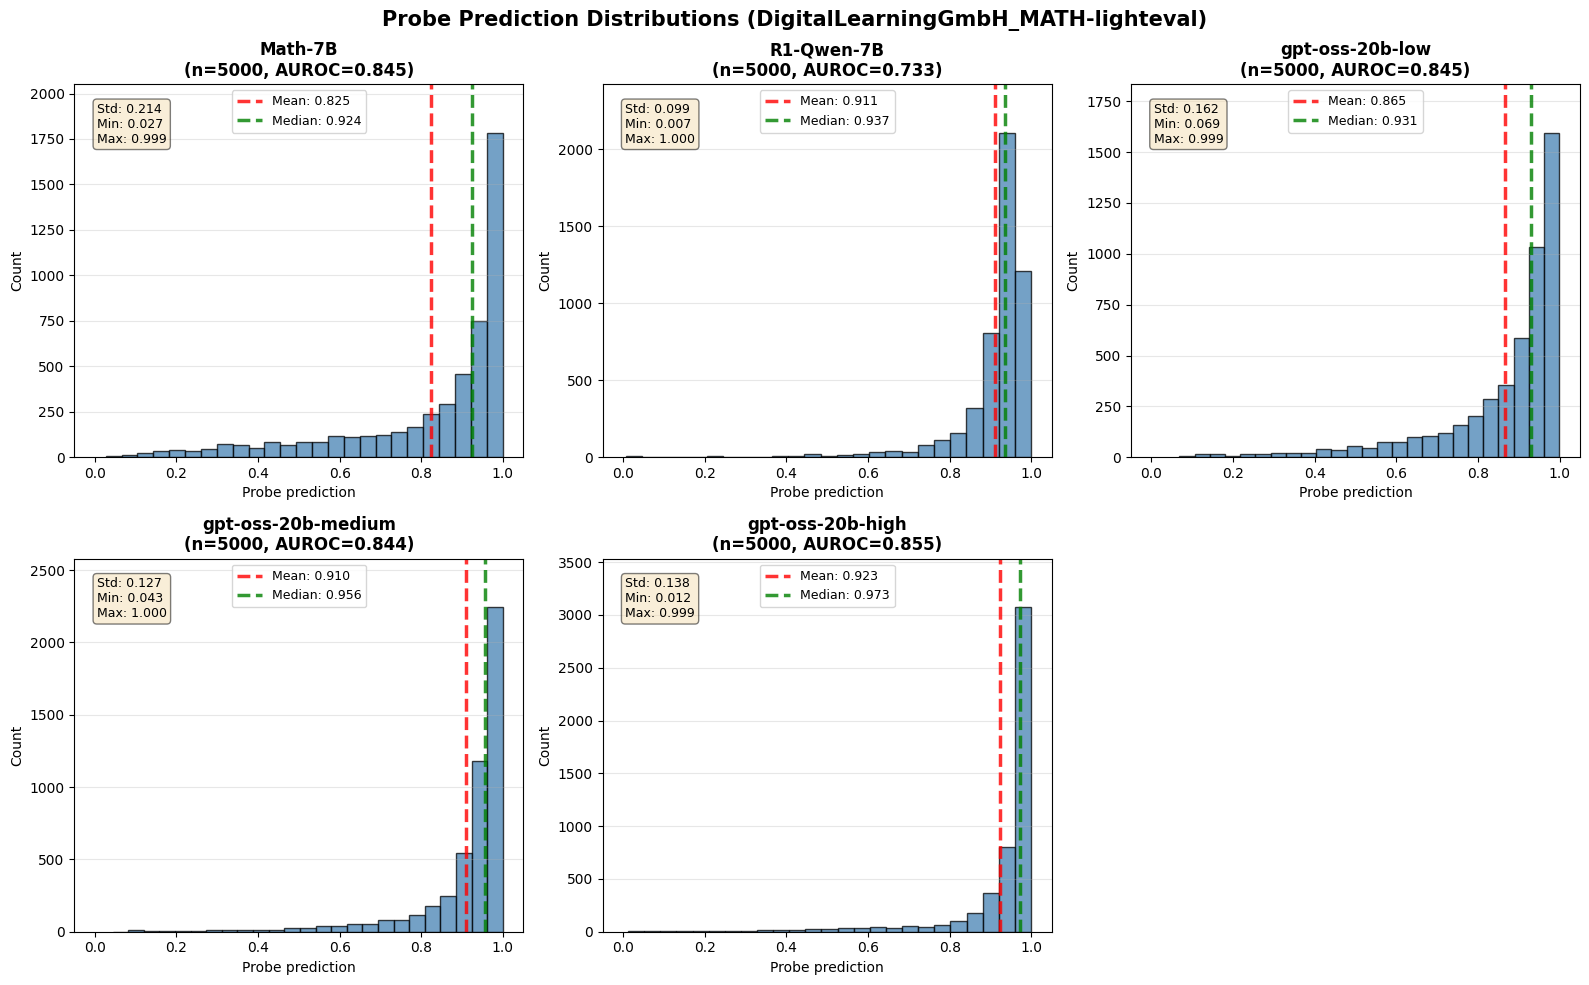

In [18]:
# ── Probe-prediction histograms ────────────────────────────
fig = plot_probe_histograms(
    test_dfs_with_probes, MODEL_POOL,
    chosen_metric=CHOSEN_METRIC,
    dataset_name=ROUTED_DATASET,
)
plt.show()

In [19]:
# ── Baseline routing strategies ─────────────────────────────
routed_df_random = route_problems_by_probe_pred(
    test_dfs_with_probes, MODEL_POOL, CHOSEN_METRIC,
    strategy="random", random_seed=42,
)
routed_df_oracle = oracle_router(
    test_dfs_with_probes, MODEL_POOL, CHOSEN_METRIC,
    tier_costs_dict=tier_costs,
)

print(f"\n✓ Oracle — cost ${routed_df_oracle['total_output_cost_usd'].sum():.2f}, "
      f"acc {routed_df_oracle[CHOSEN_METRIC].mean():.1%}")

Oracle router: 5 models — ['Qwen2.5-Math-7B-Instruct', 'DeepSeek-R1-Distill-Qwen-7B', 'gpt-oss-20b_low', 'gpt-oss-20b_medium', 'gpt-oss-20b_high']

✓ Oracle — cost $6.37, acc 95.7%


In [20]:
# ── Oracle utility sweep (theoretical upper bound) ─────────
lambda_values = np.linspace(0, 1, SWEEP_VALUE_AMOUNTS)

oracle_utility_sweep = {}
for lam in lambda_values:
    oracle_utility_sweep[f"oracle_util_{lam:.6f}"] = route_problems_oracle_utility(
        test_dfs_with_probes, MODEL_POOL, CHOSEN_METRIC,
        lambda_val=lam, tier_costs_dict=tier_costs_normalized,
    )

print(f"✓ Oracle utility sweep: {len(oracle_utility_sweep)} variants")
for target in [0.0, 0.25, 0.5, 0.75, 1.0]:
    closest = min(lambda_values, key=lambda x: abs(x - target))
    df = oracle_utility_sweep[f"oracle_util_{closest:.6f}"]
    print(f"  λ={closest:.2f}: acc={df[CHOSEN_METRIC].mean():.1%}, cost=${df['total_output_cost_usd'].sum():.2f}")

✓ Oracle utility sweep: 50 variants
  λ=0.00: acc=95.7%, cost=$8.39
  λ=0.24: acc=95.7%, cost=$6.37
  λ=0.49: acc=95.7%, cost=$6.37
  λ=0.76: acc=95.7%, cost=$6.37
  λ=1.00: acc=95.3%, cost=$5.21


In [21]:
# ── Probe-based router sweep ───────────────────────────────
routed_utility_variants = {}
for lam in lambda_values:
    name = f"og_{lam:.6f}"
    routed_utility_variants[name] = route_problems_by_probe_pred(
        test_dfs_with_probes, MODEL_POOL, CHOSEN_METRIC,
        strategy="max_utility", value=lam,
        tier_costs_dict=tier_costs_normalized,
        utility_variant=name,
    )

print(f"✓ Router sweep: {len(routed_utility_variants)} λ values (normalised costs)")

✓ Router sweep: 50 λ values (normalised costs)


In [22]:
# ── Assemble comparison data ───────────────────────────────
comparison_data = build_comparison_data(
    test_dfs_with_probes, MODEL_POOL, CHOSEN_METRIC,
    routed_random=routed_df_random,
    routed_oracle=routed_df_oracle,
    routed_variants=routed_utility_variants,
    oracle_utility_sweep=oracle_utility_sweep,
)

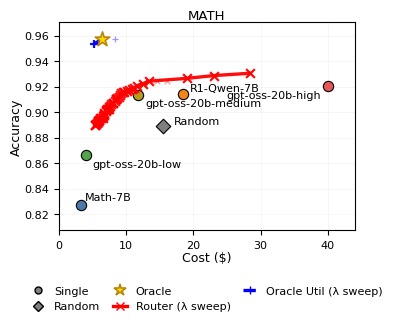

In [23]:
# ── Pareto plot ────────────────────────────────────────────
LABEL_TWEAKS = {
    "Math-1.5B":   dict(dx=3,   dy=8),
    "Math-7B":     dict(dx=3,   dy=2),
    "R1-Qwen-7B":  dict(dx=5,   dy=0),
    "GPT-Low":     dict(dx=-50, dy=-8),
    "GPT-Med":     dict(dx=-40, dy=10),
    "GPT-High":    dict(dx=10,  dy=-8, ha="right"),
}

fig, ax = plot_cost_vs_accuracy(
    comparison_data,
    metric_col=CHOSEN_METRIC,
    title=dataset_title(ROUTED_DATASET),
    xscale="auto",
    robust_xlim=False,
    label_tweaks=LABEL_TWEAKS,
    frontier_highlight_k=7,
)
# fig.savefig(f"../figs/{ROUTED_DATASET}_pareto.png", dpi=400, bbox_inches="tight", pad_inches=0.02)
plt.show()

In [ ]:
summary_rows = []
for lam in lambda_values:
    df_r = routed_utility_variants[f"og_{lam:.6f}"]
    summary_rows.append(
        {
            "lambda": float(lam),
            "accuracy": df_r[CHOSEN_METRIC].mean(),
            "cost": df_r["total_output_cost_usd"].sum(),
        }
    )

lambda_summary_df = pd.DataFrame(summary_rows)
lambda_summary_df

,lambda,accuracy,cost
0,0.000000,0.9304,28.366117
1,0.020408,0.9286,23.017902
2,0.040816,0.9264,18.970119
3,0.061224,0.9242,16.105239
4,0.081633,0.9242,14.564217
5,0.102041,0.9242,13.354909
6,0.122449,0.9222,12.480219
7,0.142857,0.9206,11.671445
8,0.163265,0.9190,11.224237
9,0.183673,0.9182,10.803778


In [28]:
lambda_summary_df.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & lambda & accuracy & cost \\\\\n\\midrule\n0 & 0.000000 & 0.930400 & 28.366117 \\\\\n1 & 0.020408 & 0.928600 & 23.017902 \\\\\n2 & 0.040816 & 0.926400 & 18.970119 \\\\\n3 & 0.061224 & 0.924200 & 16.105239 \\\\\n4 & 0.081633 & 0.924200 & 14.564217 \\\\\n5 & 0.102041 & 0.924200 & 13.354909 \\\\\n6 & 0.122449 & 0.922200 & 12.480219 \\\\\n7 & 0.142857 & 0.920600 & 11.671445 \\\\\n8 & 0.163265 & 0.919000 & 11.224237 \\\\\n9 & 0.183673 & 0.918200 & 10.803778 \\\\\n10 & 0.204082 & 0.917000 & 10.353287 \\\\\n11 & 0.224490 & 0.916400 & 10.143584 \\\\\n12 & 0.244898 & 0.915600 & 9.712779 \\\\\n13 & 0.265306 & 0.915400 & 9.468292 \\\\\n14 & 0.285714 & 0.914600 & 9.217647 \\\\\n15 & 0.306122 & 0.913200 & 9.032833 \\\\\n16 & 0.326531 & 0.911600 & 8.854830 \\\\\n17 & 0.346939 & 0.911000 & 8.648620 \\\\\n18 & 0.367347 & 0.910400 & 8.549561 \\\\\n19 & 0.387755 & 0.910000 & 8.461638 \\\\\n20 & 0.408163 & 0.908600 & 8.288807 \\\\\n21 & 0.428571 & 0.907400 & 8.086710

In [39]:
# Create full Pareto dataframe with all models and lambda variants
pareto_rows = []

# Add individual models from the pool
for model in MODEL_POOL:
    if model in test_dfs:
        df = test_dfs[model]
        pareto_rows.append({
            'strategy': f'Always {short_model_name(model)}',
            'model': model,
            'lambda': None,
            'accuracy': df[CHOSEN_METRIC].mean(),
            'cost': df['total_output_cost_usd'].sum(),
        })

# Add random routing baseline
pareto_rows.append({
    'strategy': 'Random Routing',
    'model': 'ensemble',
    'lambda': None,
    'accuracy': routed_df_random[CHOSEN_METRIC].mean(),
    'cost': routed_df_random['total_output_cost_usd'].sum(),
})

# Add oracle baseline
pareto_rows.append({
    'strategy': 'Oracle (Perfect Knowledge)',
    'model': 'ensemble',
    'lambda': None,
    'accuracy': routed_df_oracle[CHOSEN_METRIC].mean(),
    'cost': routed_df_oracle['total_output_cost_usd'].sum(),
})

# Add lambda sweep results
for lam in lambda_values:
    df_r = routed_utility_variants[f"og_{lam:.6f}"]
    pareto_rows.append({
        'strategy': f'Probe Router (λ={lam:.2f})',
        'model': 'ensemble',
        'lambda': float(lam),
        'accuracy': df_r[CHOSEN_METRIC].mean(),
        'cost': df_r['total_output_cost_usd'].sum(),
    })

pareto_df = pd.DataFrame(pareto_rows)
pareto_df = pareto_df.sort_values('cost')

In [38]:
def create_routing_table_advanced(pareto_df, 
                                  lambda_values_to_show=None,
                                  output_file='routing_table.tex'):
    """
    More flexible version with explicit lambda selection.
    
    Parameters:
    -----------
    lambda_values_to_show : list or None
        Specific lambda values to include. If None, shows [0.0, 0.1, ..., 1.0]
    """
    
    if lambda_values_to_show is None:
        lambda_values_to_show = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    df = pareto_df.copy()
    
    # Simplify model names
    df['model_short'] = df['model'].str.replace('Qwen/', '').str.replace('openai/', '').str.replace('deepseek-ai/', '')
    df['model_short'] = df['model_short'].str.replace('gpt-oss-20b_', 'gpt-oss-20b (').str.replace('_low', 'low)').str.replace('_medium', 'medium)').str.replace('_high', 'high)')
    
    # Build table rows
    rows = []
    
    # Single models
    single_models = df[df['strategy'].str.startswith('Always')].sort_values('cost')
    for _, row in single_models.iterrows():
        rows.append({
            'section': 'Single-model baselines',
            'strategy': row['strategy'].replace('Always ', ''),
            'model': row['model_short'],
            'accuracy': row['accuracy'],
            'cost': row['cost'],
            'lambda': np.nan,
            'order': 1
        })
    
    # Random and Oracle
    for strategy_name in ['Random Routing', 'Oracle (Perfect Knowledge)']:
        subset = df[df['strategy'] == strategy_name]
        if not subset.empty:
            row = subset.iloc[0]
            rows.append({
                'section': 'Routing strategies',
                'strategy': strategy_name,
                'model': row['model_short'],
                'accuracy': row['accuracy'],
                'cost': row['cost'],
                'lambda': np.nan,
                'order': 2
            })
    
    # Probe routers
    probe_df = df[df['strategy'].str.startswith('Probe Router')].copy()
    for lambda_val in lambda_values_to_show:
        matching = probe_df[np.abs(probe_df['lambda'] - lambda_val) < 0.01]
        if not matching.empty:
            row = matching.iloc[0]
            rows.append({
                'section': 'Probe router',
                'strategy': f'Probe Router ($\\lambda={lambda_val:.2f}$)',
                'model': row['model_short'],
                'accuracy': row['accuracy'],
                'cost': row['cost'],
                'lambda': lambda_val,
                'order': 3
            })
    
    # Convert to DataFrame
    table_df = pd.DataFrame(rows)

    # Generate LaTeX
    latex = []
    latex.append(r'\begin{table}[h!]')
    latex.append(r'\centering')
    latex.append(r'\caption{Routing strategies comparison on MATH benchmark}')
    latex.append(r'\label{tab:MATH_routing_results}')
    latex.append(r'\begin{tabular}{llrr}')
    latex.append(r'\toprule')
    latex.append(r'Strategy & Model & Accuracy & Cost \\')
    latex.append(r'\midrule')
    
    for section in ['Single-model baselines', 'Routing strategies', 'Probe router']:
        section_df = table_df[table_df['section'] == section]
        if not section_df.empty:
            if section != 'Single-model baselines':
                latex.append(r'\midrule')
            latex.append(f"\\multicolumn{{4}}{{l}}{{\\textit{{{section}}}}} \\\\")
            
            for _, row in section_df.iterrows():
                latex.append(
                    f"{row['strategy']} & {row['model']} & "
                    f"{row['accuracy']:.3f} & {row['cost']:.2f} \\\\"
                )
    
    latex.append(r'\bottomrule')
    latex.append(r'\end{tabular}')
    latex.append(r'\end{table}')
    
    latex_content = '\n'.join(latex)
    
    with open(output_file, 'w') as f:
        f.write(latex_content)
    
    return latex_content

# Usage with custom lambda values
custom_lambdas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
table = create_routing_table_advanced(pareto_df, lambda_values_to_show=custom_lambdas)
print(table)

\begin{table}[h!]
\centering
\caption{Routing strategies comparison on MATH benchmark}
\label{tab:MATH_routing_results}
\begin{tabular}{llrr}
\toprule
Strategy & Model & Accuracy & Cost \\
\midrule
\multicolumn{4}{l}{\textit{Single-model baselines}} \\
Math-7B & Qwen2.5-Math-7B-Instruct & 0.827 & 3.28 \\
gpt-oss-20b-low & gpt-oss-20b (low & 0.866 & 4.00 \\
gpt-oss-20b-medium & gpt-oss-20b (medium & 0.914 & 11.78 \\
R1-Qwen-7B & DeepSeek-R1-Distill-Qwen-7B & 0.914 & 18.43 \\
gpt-oss-20b-high & gpt-oss-20b (high & 0.920 & 40.00 \\
\midrule
\multicolumn{4}{l}{\textit{Routing strategies}} \\
Random Routing & ensemble & 0.889 & 15.43 \\
Oracle (Perfect Knowledge) & ensemble & 0.957 & 6.37 \\
\midrule
\multicolumn{4}{l}{\textit{Probe router}} \\
Probe Router ($\lambda=0.00$) & ensemble & 0.930 & 28.37 \\
Probe Router ($\lambda=0.20$) & ensemble & 0.917 & 10.35 \\
Probe Router ($\lambda=0.40$) & ensemble & 0.909 & 8.29 \\
Probe Router ($\lambda=0.60$) & ensemble & 0.902 & 7.02 \\
Probe Router